In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV,ElasticNetCV
from pyentrp import entropy as pyent
import EntropyHub as EH
import neurokit2 as nk
import random
import sampen
import requests
import io
from pprint import pprint
import os
from sklearn import preprocessing
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import SYNCHRONOUS
from influxdb_client.client.flux_table import FluxTable
import datetime
from typing import List
import itertools
import datetime
from statsmodels.stats.diagnostic import breaks_cusumolsresid
import npd_entropy
from sidpy import *


In [20]:
a = np.random.randint(1000, 10000, 1000)
b = np.random.randint(2000, 4000, 1000)

In [21]:
len(np.append(a, b))

2000

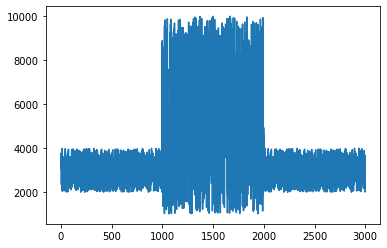

In [23]:
plt.plot(np.append(b, np.append(a, b)))

In [24]:
def compute_enet( x_train, y_train, alpha = 1.0, l1_ratio = 0.5) -> ElasticNet:
    return ElasticNet(alpha=alpha, l1_ratio=l1_ratio).fit(x_train, y_train)

def enet_loop(x, y, alpha = 1.0, l1_ratio = 0.5, batch_size = 300, incr = 30):
    y_pred = pd.DataFrame([])
    counter = batch_size
    while len(x) > counter:
        try:
            x_train = x[counter-batch_size:counter]
            y_train = y[counter-batch_size:counter]
            x_test = x[counter:counter+incr].reshape(-1, 1)
            enet = compute_enet(x_train, y_train, alpha, l1_ratio)
            target_y_pred = enet.predict(x_test)
            y_pred = y_pred.append(pd.DataFrame(target_y_pred), ignore_index=True)
            counter += incr
        except Exception as e:
            print(e)
            counter += incr
    return y_pred

In [12]:
def sampen_loop(ser: List[float], batch_size = 300) -> List[float]:
    return [nk.entropy_sample(np.array(ser[index-batch_size:index]))[0] for index in range(len(ser))[batch_size:]]

In [8]:
def fuzzy_loop(ser: List[float], batch_size = 300) -> List[float]:
    return [nk.entropy_fuzzy(np.array(ser[index-batch_size:index]))[0] for index in range(len(ser))[batch_size:]]

In [13]:
### Range distance for RangeEn_B and RangeEn_A
def dist_range(x, y):
  return (np.max(np.abs(x - y), axis=1) - np.min(np.abs(x - y), axis=1)) / (np.max(np.abs(x - y), axis=1) + np.min(np.abs(x - y), axis=1))

### RangeEn-A (mApEn)
def RangeEn_A(x, emb_dim=2, tolerance=.2, dist=dist_range):

    n = np.shape(x)
    n = np.max(n)

    tVecs = np.zeros((n - emb_dim, emb_dim + 1))
    for i in range(tVecs.shape[0]):
        tVecs[i, :] = x[i:i + tVecs.shape[1]]
    counts = []
    for m in [emb_dim, emb_dim + 1]:
        # get the matrix that we need for the current m
        tVecsM = tVecs[:n - m + 1, :m]
        # successively calculate distances between each pair of template vectors
        C = []
        for i in range(len(tVecsM)):
            dsts = dist(tVecsM, tVecsM[i])
            # delete undefined distances coming from zero segments
            # dsts = [x for i, x in enumerate(dsts) if not np.isnan(x) and not np.isinf(x)]
            # count how many 'defined' distances are smaller than the tolerance
            # if(dsts):
            C.append((np.sum(dsts < tolerance)) / (n - m))
        # compute sum of log probabilities
        counts.append((np.sum(np.log(C))) / (n - m))

    RangeEn_A = counts[0] - counts[1]

    return RangeEn_A

##### RangeEn-B (mSampEn)
def RangeEn_B(x, emb_dim=2, tolerance=.2, dist=dist_range):

    n = np.shape(x)
    n = np.max(n)

    tVecs = np.zeros((n - emb_dim, emb_dim + 1))
    for i in range(tVecs.shape[0]):
        tVecs[i, :] = x[i:i + tVecs.shape[1]]
    counts = []
    for m in [emb_dim, emb_dim + 1]:
        counts.append(0)
        # get the matrix that we need for the current m
        tVecsM = tVecs[:n - m + 1, :m]
        # successively calculate distances between each pair of template vectors
        for i in range(len(tVecsM)):
            dsts = dist(tVecsM, tVecsM[i])
            # delete self-matching
            dsts = np.delete(dsts, i, axis=0)
            # delete undefined distances coming from zero segments
            # dsts = [x for i, x in enumerate(dsts) if not np.isnan(x) and not np.isinf(x)]
            # count how many 'defined' distances are smaller than the tolerance
            # if (dsts):
            counts[-1] += np.sum(dsts < tolerance)/(n - m - 1)

    if counts[1] == 0:
        # log would be infinite => cannot determine RangeEn_B
        RangeEn_B = np.nan
    else:
        # compute log of summed probabilities
        RangeEn_B = -np.log(1.0 * counts[1] / counts[0])

    return RangeEn_B

In [14]:
def rangenb_loop(ser: List[float], batch_size = 300) -> List[float]:
    return [RangeEn_B(np.array(ser[index-batch_size:index])) for index in range(len(ser))[batch_size:]]

In [44]:
a = np.random.randint(1500, 10000, 1000)
b = np.random.randint(1000, 1050, 1000)
random_base = np.append(b, np.append(a, b))

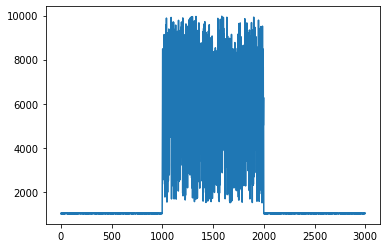

In [45]:
plt.plot(random_base)

In [40]:
rangenb= rangenb_loop(random_base)

/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_32827/832245642.py:3: RuntimeWarning: invalid value encountered in true_divide
  return (np.max(np.abs(x - y), axis=1) - np.min(np.abs(x - y), axis=1)) / (np.max(np.abs(x - y), axis=1) + np.min(np.abs(x - y), axis=1))


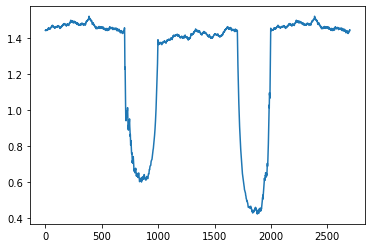

In [41]:
plt.plot(rangenb)

In [46]:
sampen = sampen_loop(random_base)

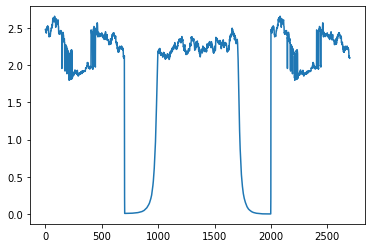

In [47]:
plt.plot(sampen)

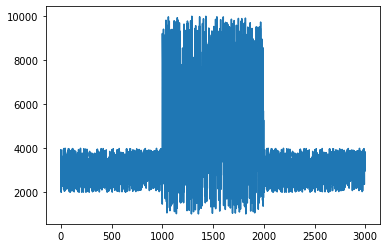

In [56]:
a = np.random.randint(1000, 10000, 1000)
b = np.random.randint(2000, 4000, 1000)
base_1= np.append(b, np.append(a, b))
plt.plot(base_1)

In [58]:
sampen_1 = sampen_loop(random_base)

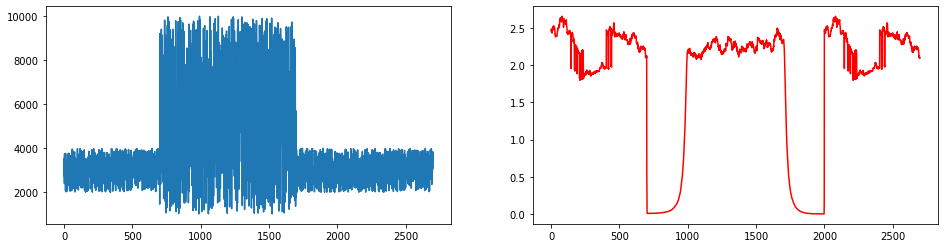

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].plot(base_1[300:])
axes[1].plot(sampen_1, color='red')


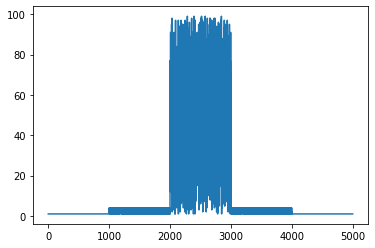

In [71]:
a = np.random.randint(1, 2, 1000)
b = np.random.randint(1, 5, 1000)
c = np.random.randint(1, 100, 1000)
base_2 = np.append(np.append(a, np.append(b, np.append(c, b))), a)
plt.plot(base_2)

In [38]:
sampen_2 = sampen_loop(base_2)
plt.plot(sampen_2)

NameError: name 'base_2' is not defined

/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_32827/832245642.py:3: RuntimeWarning: invalid value encountered in true_divide
  return (np.max(np.abs(x - y), axis=1) - np.min(np.abs(x - y), axis=1)) / (np.max(np.abs(x - y), axis=1) + np.min(np.abs(x - y), axis=1))


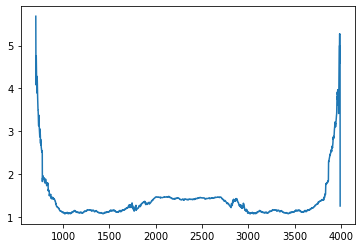

In [73]:
rangenb_2 = rangenb_loop(base_2)
plt.plot(rangenb_2)

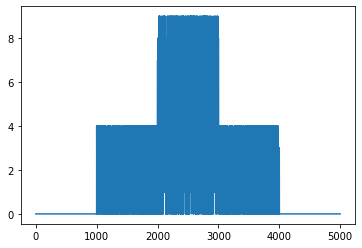

In [70]:
plt.plot(base_2)

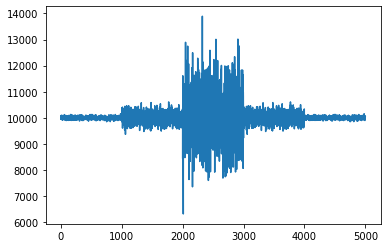

In [9]:
# np.random.normal(mean, std, size)
samples_1 = np.random.normal(10000, 50, size=1000)
samples_2 = np.random.normal(10000, 200, size=1000)
samples_3 = np.random.normal(10000, 1000, size=1000)

plt.plot(samples_1.tolist()+samples_2.tolist()+samples_3.tolist()+samples_2.tolist()+samples_1.tolist())
plt.show()

In [15]:
base_3 = samples_1.tolist()+samples_2.tolist()+samples_3.tolist()+samples_2.tolist()+samples_1.tolist()

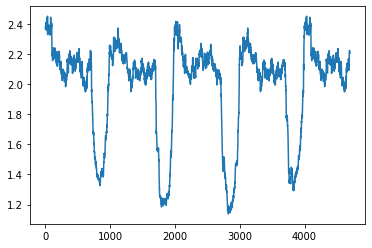

In [16]:
sampen_3 = sampen_loop(base_3)
plt.plot(sampen_3)

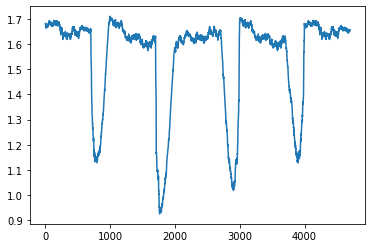

In [17]:
fuzzy_3 = fuzzy_loop(base_3)
plt.plot(fuzzy_3)

/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_5605/832245642.py:3: RuntimeWarning: invalid value encountered in true_divide
  return (np.max(np.abs(x - y), axis=1) - np.min(np.abs(x - y), axis=1)) / (np.max(np.abs(x - y), axis=1) + np.min(np.abs(x - y), axis=1))


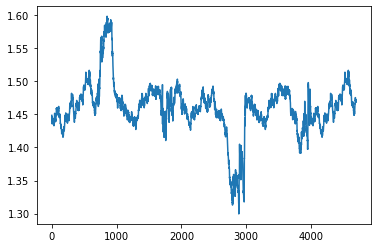

In [18]:
rangen_3 = rangenb_loop(base_3)
plt.plot(rangen_3)

In [58]:
import numpy as np
import pandas as pd
from scipy.linalg import hankel
from scipy.spatial.distance import pdist
from typing import List
import sys
import math

def disten(ser: List[float], m: int = 2, tau: int = 8 , B: int = 512) -> float:
    """
    @param ser: time-series (vector in a column)
    @param m: embedding dimension (scalar)
    @param tau: time delay (scalar)
    @param B: bin number for histogram (scalar)
    """

    # rescaling
    rescaled = [y / (max(ser) - min(ser) + sys.float_info.epsilon) for y in [x - min(ser) for x in ser]]

    # distance matrix
    N = len(rescaled) - (m - 1) * tau
    if N < 0:
        raise(f"ser is too short: {len(ser)}")
    ind = hankel(np.arange(1, N+1), np.arange(N, len(rescaled)+1))
    rnt = [[rescaled[z-1] for z in y] for y in [x[::tau] for x in ind]]
    dv = pdist(rnt, 'chebychev')

    # esimating probability density by histogram
    num = pd.cut(dv, np.linspace(0, 1, B), include_lowest=True).value_counts().to_numpy()
    freq = [x / num.sum() for x in num]

    # disten calculation
    prepared = [math.log2(y) for y in [x + sys.float_info.epsilon for x in freq]]
    return -sum([x * y for (x, y) in zip(prepared, freq)]) / math.log2(B)

In [59]:
def disten_loop(ser: List[float], batch_size = 300) -> List[float]:
    return [disten(ser[index:index+batch_size]) for index in range(len(ser[batch_size:]))]

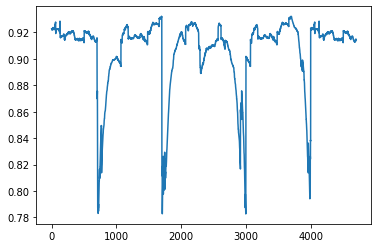

In [90]:
disten_3 = disten_loop(base_3)
plt.plot(disten_3)

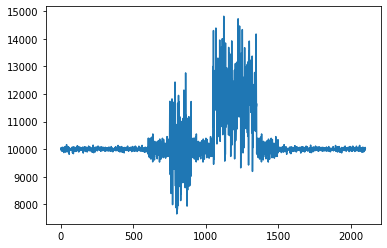

In [2]:
# np.random.normal(mean, std, size)
samples_1 = np.random.normal(10000, 50, size=600)
samples_2 = np.random.normal(10000, 200, size=150)
samples_3 = np.random.normal(10000, 1000, size=150)
samples_4 = np.random.normal(12000, 1100, size=300)
base_4=samples_1.tolist()+samples_2.tolist()+samples_3.tolist()+samples_2.tolist()+samples_4.tolist()+samples_2.tolist()+samples_1.tolist()

plt.plot(base_4)
plt.show()

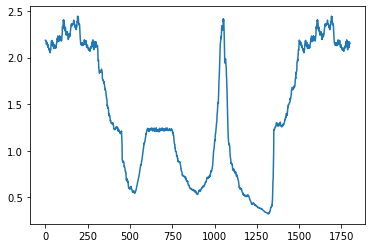

In [42]:
sampen_4 = sampen_loop(base_4)
plt.plot(sampen_4)

/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_5605/832245642.py:3: RuntimeWarning: invalid value encountered in true_divide
  return (np.max(np.abs(x - y), axis=1) - np.min(np.abs(x - y), axis=1)) / (np.max(np.abs(x - y), axis=1) + np.min(np.abs(x - y), axis=1))


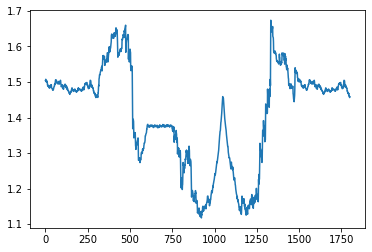

In [43]:
rangen_4 = rangenb_loop(base_4)
plt.plot(rangen_4)

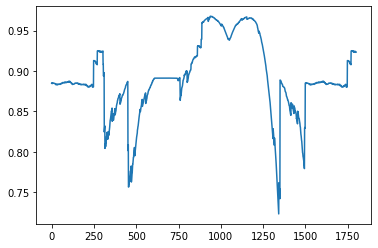

In [60]:
disten_4 = disten_loop(base_4)
plt.plot(disten_4)

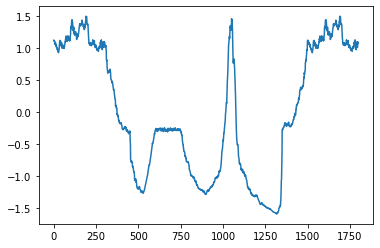

In [44]:
import scipy.stats
zscores_sampen_4 = scipy.stats.zscore(sampen_4)
plt.plot(zscores_sampen_4)

In [56]:
RangeEn_B(base_4[:300])

/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_5605/832245642.py:3: RuntimeWarning: invalid value encountered in true_divide
  return (np.max(np.abs(x - y), axis=1) - np.min(np.abs(x - y), axis=1)) / (np.max(np.abs(x - y), axis=1) + np.min(np.abs(x - y), axis=1))


1.5039780376426046

In [48]:
example_1

10006

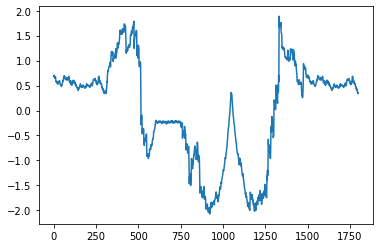

In [45]:
zscores_rangen_4 = scipy.stats.zscore(rangen_4)
plt.plot(zscores_rangen_4)

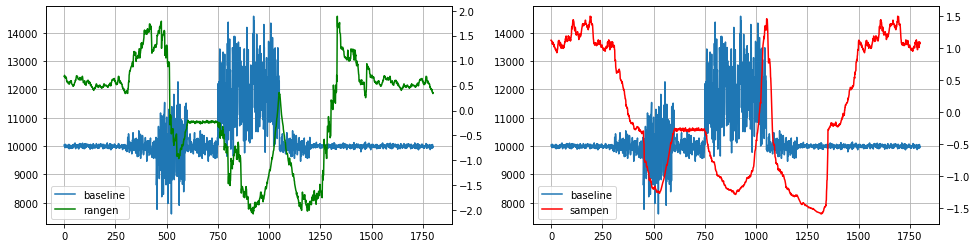

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
ln1 = axes[0].plot(base_4[300:],label='baseline')

ax1 = axes[0].twinx()
ln2 = ax1.plot(zscores_rangen_4, color='green', label="rangen")

h1, l1 = axes[0].get_legend_handles_labels()
h2, l2 = ax1.get_legend_handles_labels()
axes[0].legend(h1+h2, l1+l2, loc='lower left')

axes[0].grid(True)

rn1 = axes[1].plot(base_4[300:],label='baseline')

ax2 = axes[1].twinx()
rn2 = ax2.plot(zscores_sampen_4, color='red', label="sampen")

h3, l3 = axes[1].get_legend_handles_labels()
h4, l4 = ax2.get_legend_handles_labels()
axes[1].legend(h3+h4, l3+l4, loc='lower left')

axes[1].grid(True)

In [22]:
def calc_hurst_exponent(time_series, max_lag=20):
    """Returns the Hurst Exponent of the time series"""
    
    lags = range(2, max_lag)

    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]

    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)

    return reg[0]

In [67]:
def hurst_loop(ser: List[float], batch_size = 300) -> List[float]:
    return [calc_hurst_exponent(np.array(ser[index-batch_size:index])) for index in range(len(ser))[batch_size:]]

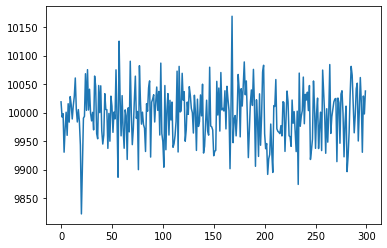

In [34]:
plt.plot(base_4[:300])

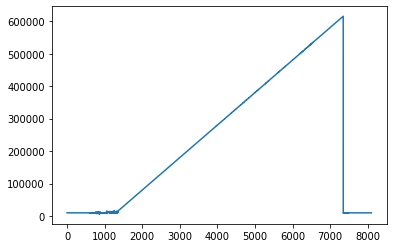

In [98]:
# np.random.normal(mean, std, size)
import random

samples_1 = np.random.normal(10000, 50, size=600)
samples_2 = np.random.normal(10000, 200, size=150)
samples_3 = np.random.normal(10000, 1000, size=150)
samples_4 = np.random.normal(12000, 1100, size=300)
base_5=samples_1.tolist()+samples_2.tolist()+samples_3.tolist()+samples_2.tolist()+samples_4.tolist()+[15000+y*random.uniform(100, 100.1) for y in range(6000)]+samples_2.tolist()+samples_1.tolist()

plt.plot(base_5)
plt.show()

In [99]:
hurst_5 = hurst_loop(base_5)

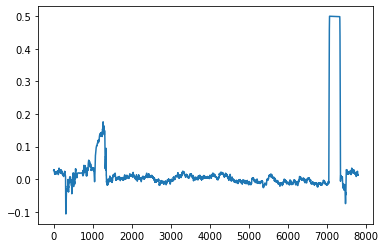

In [100]:
plt.plot(hurst_5)

In [7]:
breaks_cusumolsresid(np.array(base_4[:500]))

(22.360415150294063, 0.0, [(1, 1.63), (5, 1.36), (10, 1.22)])

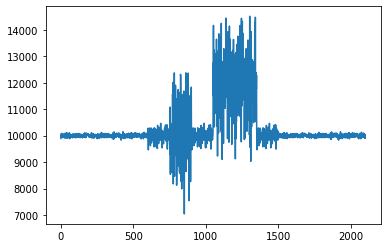

In [28]:
# np.random.normal(mean, std, size)
xsamples_1 = np.random.normal(10000, 50, size=600)
xsamples_2 = np.random.normal(10000, 200, size=150)
xsamples_3 = np.random.normal(10000, 1000, size=150)
xsamples_4 = np.random.normal(12000, 1100, size=300)
base_6=xsamples_1.tolist()+xsamples_2.tolist()+xsamples_3.tolist()+xsamples_2.tolist()+xsamples_4.tolist()+xsamples_2.tolist()+xsamples_1.tolist()

plt.plot(base_6)
plt.show()

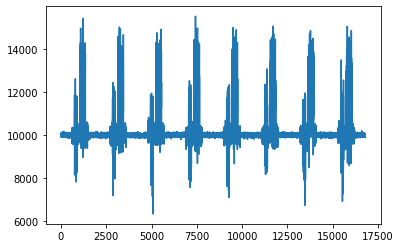

In [3]:
base_7=((np.random.normal(10000, 50, size=600).tolist()
        +np.random.normal(10000, 200, size=150).tolist()
        +np.random.normal(10000, 1000, size=150).tolist()
        +np.random.normal(10000, 200, size=150).tolist()
        +np.random.normal(12000, 1100, size=300).tolist()
        +np.random.normal(10000, 200, size=150).tolist()
        +np.random.normal(10000, 50, size=600).tolist())
        +(np.random.normal(10000, 50, size=600).tolist()
        +np.random.normal(10000, 200, size=150).tolist()
        +np.random.normal(10000, 1000, size=150).tolist()
        +np.random.normal(10000, 200, size=150).tolist()
        +np.random.normal(12000, 1100, size=300).tolist()
        +np.random.normal(10000, 200, size=150).tolist()
        +np.random.normal(10000, 50, size=600).tolist())
        +(np.random.normal(10000, 50, size=600).tolist()
        +np.random.normal(10000, 200, size=150).tolist()
        +np.random.normal(10000, 1000, size=150).tolist()
        +np.random.normal(10000, 200, size=150).tolist()
        +np.random.normal(12000, 1100, size=300).tolist()
        +np.random.normal(10000, 200, size=150).tolist()
        +np.random.normal(10000, 50, size=600).tolist())
        +(np.random.normal(10000, 50, size=600).tolist()
        +np.random.normal(10000, 200, size=150).tolist()
        +np.random.normal(10000, 1000, size=150).tolist()
        +np.random.normal(10000, 200, size=150).tolist()
        +np.random.normal(12000, 1100, size=300).tolist()
        +np.random.normal(10000, 200, size=150).tolist()
        +np.random.normal(10000, 50, size=600).tolist())
        +(np.random.normal(10000, 50, size=600).tolist()
        +np.random.normal(10000, 200, size=150).tolist()
        +np.random.normal(10000, 1000, size=150).tolist()
        +np.random.normal(10000, 200, size=150).tolist()
        +np.random.normal(12000, 1100, size=300).tolist()
        +np.random.normal(10000, 200, size=150).tolist()
        +np.random.normal(10000, 50, size=600).tolist())
        +(np.random.normal(10000, 50, size=600).tolist()
        +np.random.normal(10000, 200, size=150).tolist()
        +np.random.normal(10000, 1000, size=150).tolist()
        +np.random.normal(10000, 200, size=150).tolist()
        +np.random.normal(12000, 1100, size=300).tolist()
        +np.random.normal(10000, 200, size=150).tolist()
        +np.random.normal(10000, 50, size=600).tolist())
        +(np.random.normal(10000, 50, size=600).tolist()
        +np.random.normal(10000, 200, size=150).tolist()
        +np.random.normal(10000, 1000, size=150).tolist()
        +np.random.normal(10000, 200, size=150).tolist()
        +np.random.normal(12000, 1100, size=300).tolist()
        +np.random.normal(10000, 200, size=150).tolist()
        +np.random.normal(10000, 50, size=600).tolist())
        +(np.random.normal(10000, 50, size=600).tolist()
        +np.random.normal(10000, 200, size=150).tolist()
        +np.random.normal(10000, 1000, size=150).tolist()
        +np.random.normal(10000, 200, size=150).tolist()
        +np.random.normal(12000, 1100, size=300).tolist()
        +np.random.normal(10000, 200, size=150).tolist()
        +np.random.normal(10000, 50, size=600).tolist()))

plt.plot(base_7)
plt.show()

In [5]:
p_max = 10

nn_package = 'sklearn' # Deterministic, but slower.
# nn_package = 'pyflann' # Fast approximation, but non-deterministic.

# Determines the upper bound on the number of nearest neighbors to use
# for the computation of NLPL:

pow_upperbound = 0.5

# Determines the number of nearest neighbors to use in estimating 
# the specific entropy rate and normalized q-step specific entropy
# rate.

pow_neighbors = 0.5

# Specify whether the data is by-trial / epoched (multirealization)
# or not.

is_multirealization = False

In [6]:
p_opt, nlpl_opt, nlpl_by_p, er_knn, ler_knn = choose_model_order_nlpl(base_7, p_max, pow_upperbound = pow_upperbound, nn_package = nn_package, is_multirealization = is_multirealization, announce_stages = False, output_verbose = True)
print('Chose p* = {}, giving ER(p*) = {}'.format(p_opt, er_knn))


For p = 0, with NLPL(k = 5) = 6.933948128806345
####################################################
# Warning: For p = 1, Nelder-Mead is choosing k* near k_upper = 130.
# Increase pow_upperbound.
####################################################
For p = 1, with NLPL(h* = 0.15864749170773224, k* = 130) = 6.960095317625257


/Users/s02435/ghq/github.com/nnao45/jaist-my-jupyter/.venv/lib/python3.8/site-packages/sidpy.py:1337: RuntimeWarning: divide by zero encountered in log
  log_fs = numpy.log(fs)


####################################################
# Warning: For p = 2, Nelder-Mead is choosing k* near k_upper = 130.
# Increase pow_upperbound.
####################################################
For p = 2, with NLPL(h* = 0.13387506847467057, k* = 130) = 6.823547725805125


/Users/s02435/ghq/github.com/nnao45/jaist-my-jupyter/.venv/lib/python3.8/site-packages/sidpy.py:1337: RuntimeWarning: divide by zero encountered in log
  log_fs = numpy.log(fs)


####################################################
# Warning: For p = 3, Nelder-Mead is choosing k* near k_upper = 130.
# Increase pow_upperbound.
####################################################
For p = 3, with NLPL(h* = 0.11160951633633573, k* = 130) = 6.70897205322972


/Users/s02435/ghq/github.com/nnao45/jaist-my-jupyter/.venv/lib/python3.8/site-packages/sidpy.py:1337: RuntimeWarning: divide by zero encountered in log
  log_fs = numpy.log(fs)


####################################################
# Warning: For p = 4, Nelder-Mead is choosing k* near k_upper = 130.
# Increase pow_upperbound.
####################################################
For p = 4, with NLPL(h* = 0.12347152903728845, k* = 130) = 6.755627901285609


/Users/s02435/ghq/github.com/nnao45/jaist-my-jupyter/.venv/lib/python3.8/site-packages/sidpy.py:1337: RuntimeWarning: divide by zero encountered in log
  log_fs = numpy.log(fs)


####################################################
# Warning: For p = 5, Nelder-Mead is choosing k* near k_upper = 130.
# Increase pow_upperbound.
####################################################
For p = 5, with NLPL(h* = 0.12138475766207696, k* = 130) = 6.743000538011902


/Users/s02435/ghq/github.com/nnao45/jaist-my-jupyter/.venv/lib/python3.8/site-packages/sidpy.py:1337: RuntimeWarning: divide by zero encountered in log
  log_fs = numpy.log(fs)


####################################################
# Warning: For p = 6, Nelder-Mead is choosing k* near k_upper = 130.
# Increase pow_upperbound.
####################################################
For p = 6, with NLPL(h* = 0.123522878860529, k* = 130) = 6.7519944690686025


/Users/s02435/ghq/github.com/nnao45/jaist-my-jupyter/.venv/lib/python3.8/site-packages/sidpy.py:1337: RuntimeWarning: divide by zero encountered in log
  log_fs = numpy.log(fs)


####################################################
# Warning: For p = 7, Nelder-Mead is choosing k* near k_upper = 130.
# Increase pow_upperbound.
####################################################
For p = 7, with NLPL(h* = 0.13240366170154677, k* = 130) = 6.79121351483185


/Users/s02435/ghq/github.com/nnao45/jaist-my-jupyter/.venv/lib/python3.8/site-packages/sidpy.py:1337: RuntimeWarning: divide by zero encountered in log
  log_fs = numpy.log(fs)


####################################################
# Warning: For p = 8, Nelder-Mead is choosing k* near k_upper = 130.
# Increase pow_upperbound.
####################################################
For p = 8, with NLPL(h* = 0.1340125074171592, k* = 130) = 6.7998255610646945


/Users/s02435/ghq/github.com/nnao45/jaist-my-jupyter/.venv/lib/python3.8/site-packages/sidpy.py:1337: RuntimeWarning: divide by zero encountered in log
  log_fs = numpy.log(fs)


####################################################
# Warning: For p = 9, Nelder-Mead is choosing k* near k_upper = 130.
# Increase pow_upperbound.
####################################################
For p = 9, with NLPL(h* = 0.13817598779749923, k* = 130) = 6.815722731546707


/Users/s02435/ghq/github.com/nnao45/jaist-my-jupyter/.venv/lib/python3.8/site-packages/sidpy.py:1337: RuntimeWarning: divide by zero encountered in log
  log_fs = numpy.log(fs)


####################################################
# Warning: For p = 10, Nelder-Mead is choosing k* near k_upper = 130.
# Increase pow_upperbound.
####################################################
For p = 10, with NLPL(h* = 0.1431951420018126, k* = 130) = 6.836600527899159
Chose p* = 3, giving ER(p*) = 6.324174975888591


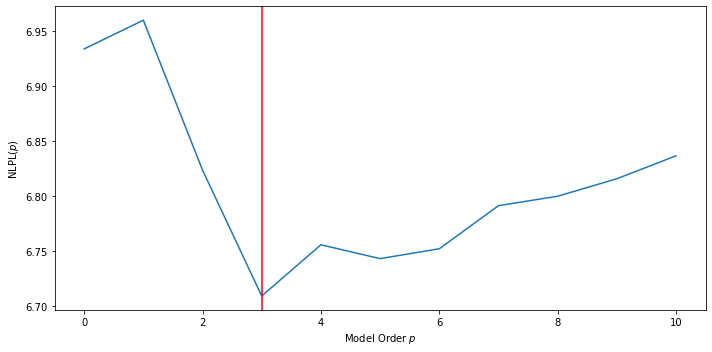

In [7]:
plt.figure(figsize = (10, 5))
plt.plot(range(0, p_max + 1), nlpl_by_p)
plt.xlabel('Model Order $p$')
plt.ylabel('NLPL$(p)$')
plt.axvline(p_opt, color = 'r')
plt.tight_layout()

In [9]:
print('Estimating local entropy rate in-sample...')

ler = estimate_ler_insample(base_7, p_opt = p_opt, pow_neighbors = pow_neighbors)

print('Estimating specific entropy rate in-sample...')

ser = estimate_ser_insample(base_7, ler_knn, p_opt = p_opt, pow_neighbors = pow_neighbors)

Estimating local entropy rate in-sample...
Estimating specific entropy rate in-sample...
